# 4 - Influential Classification Models (and Tools)

## Introduction

This Notebook (4) will continue on from the previous sections. This notebook will go through the process of using __Keras Applications and reusing model__. Previously, the notebook focused on implementing the ResNet model from scratch, here, the intention is to utilise the models that were curated from Keras Applications and be used as direct comparison with the self-implemented version.

## Supporting Utilities .py files:

In this Notebook, there will be a requirement to import the code/utilities from the following files (.py files):
- DataPrepCIFAR_utility.py
- customCallbacks_Keras.py

## Dataset:

For this part of the project, the CIFAR-100 dataset will be used, it is a collection of of 60,000 32x32 images that have 100 classes. CIFAR-100 was originally collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It iss also a subset of the 80 million tiny images dataset. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses.

Source: https://www.cs.toronto.edu/~kriz/cifar.html

Further, the TensorFlow team offers a python package called "tensorflow_datasets" that provides the helper function to download tthis dataset as well as other more common ones. For the purposes of this project, the CIFAR-100 dataset will be download with this package.

Source: https://www.tensorflow.org/datasets/catalog/cifar100

## Requirements:
- Tensorflow 2.0 (GPU is better)
- Tensorflow-Hub
- Keras (GPU is better)

### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import math
import timeit

In [2]:
import os
# from IPython.display import display, Image
# import matplotlib.pyplot as plt

# %matplotlib inline

# Set up the working directory for the images:
image_folderName = 'Description Images'
image_path = os.path.abspath(image_folderName) + '/'

In [3]:
# Set the random set seed number: for reproducibility.
Seed_nb = 42

### GPU Information:

In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
devices = sess.list_devices()
devices

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5



[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 3464511987518476392),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 6586313605, 5164781978785170762)]

## 1 - Hyperparameters:

In [5]:
input_shape = [224, 224, 3]
batch_size = 64
nb_epochs = 300

## 2 - Data Preparation and Defining the Input Pipeline:

To use the TensorFlow package, please ensure to install it: "pip install tensorflow-datasets" or use the Anaconda Navigator.

## 2.1 - Download the Dataset:

In [6]:
import tensorflow_datasets as tfds
import DataPrepCIFAR_utility

In [7]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [8]:
# Get the Dataset Information:
cifarData_info = DataPrepCIFAR_utility.get_info()
print(cifarData_info)

tfds.core.DatasetInfo(
    name='cifar100',
    version=1.3.1,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multi

## 2.2 - Set up the dataset:

In [9]:
# Set the number of classes:
nb_classes = cifarData_info.features['label'].num_classes

# Define the number of images for training and validation:
nb_train_imgs = cifarData_info.splits['train'].num_examples
nb_valid_imgs = cifarData_info.splits['test'].num_examples

## 2.3 - Set the "steps_per_epoch" for Training and Validation Set:

From the previous code block, the dataset is compatible with Keras methods liike "model.fit()", but will also require the "steps_per_epoch" to be specified. This is the number of batches per epoch of the Dataset objects that has to be specified for the Keras method so that it can work properly together. This is done for the training batches ("steps_per_epoch") and validation batches ("validation_steps").

In [10]:
train_steps_per_epoch = math.ceil(nb_train_imgs / batch_size)

valid_steps_per_epoch = math.ceil(nb_valid_imgs / batch_size)

## 2.4 - Load in the Dataset:

In [11]:
# Training Dataset:
train_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='train',
                                                    batch_size= batch_size,
                                                    nb_epochs= nb_epochs,
                                                    shuffle=True,
                                                    input_shape= input_shape,
                                                    seed= Seed_nb)

# Validation Dataset:
val_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='test',
                                                  batch_size= batch_size,
                                                  nb_epochs= 1,
                                                  shuffle= False,
                                                  input_shape= input_shape,
                                                  seed= Seed_nb)

Now that the CIFAR-100 dataset has been prepared. The next stage is to call the ResNet model.

## 3 - Grab the ResNet-50 model from Keras Applications:

Keras Applications consists of many well-curated models. Keras Applications are deep learning models that are made available from the team and it also contains the pre-trained weights for each of these model. These models can be immediately used for prediction, feature extraction, and fine-tuning. The model that will be instantiated here will be the ResNet-50 model. 

## 3.1 - Instatiate the ResNet-50 model:

Like the previous notebooks, the image sizes for the CIFAR-100 are to be set as 224x224 pixel sizes, as suggested by the creators of ResNet.

In [12]:
# Instantiate the model:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True,
                                                   weights= None,
                                                   input_shape= input_shape,
                                                   classes= nb_classes
                                                  )

# Model Summary:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## 3.2 - Comparison to the Self-implemented model:

Self-implement ResNet model have the following specifications:
- Total params: 23,777,252
- Trainable params: 23,731,812
- Non-trainable params: 45,440

Keras Applications ResNet model have the following specifications:
- Total params: 23,792,612
- Trainable params: 23,739,492
- Non-trainable params: 53,120

As it can be seen, the total number of parameters are slightly different. To find out more to why this is, a more detailed comparison of the code between the two models will be required. The link to the official implementation is: https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py

## 4 - Training the ResNet-50 Model:

With the ResNet model instantiated, the model can now be trained on the dataset. There will be a need to call the "customCallbacks_Keras.py" for this section.

## 4.1 - Preparation for Training:

In [13]:
# Import the required libraries:
from customCallbacks_Keras import Simplified_LogCallback
import collections

In [14]:
# Define the model optimiser:
optimiser = tf.keras.optimizers.Adam()

# Define the accuracy metric:
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name = 'acc')

# Define the top-5 accuracy metric: a.k.a Top-K
top5_acc_metric = tf.metrics.SparseTopKCategoricalAccuracy(k = 5,
                                                           name = 'top5_acc')

In [15]:
# Callback to log metrics at the end of each epoch: this saves space compared to Verbose = 1.
metrics_to_print = collections.OrderedDict( [("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"), 
                                            ("v-top5-acc", "val_top5_acc")] 
                                          )

In [16]:
# Define the model directtory:
# model_dir = './models/ResNet50_run1'
# model_dir = '.\models\ResNet50_run1'
model_dir = '.\models\ResNet50_run3' # This should be ResNet152 not ResNet50.

# Define the Callbacks:
callbacks = [
    
    # Callback to interrupt the training if the validation loss/metric stops imrpoving for some amount of epochs:
    tf.keras.callbacks.EarlyStopping(monitor ='val_acc',
                                    patience =8,
                                    restore_best_weights = True
                                    ),
    
    # Callback to log the graph, Losses and Metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir = model_dir,
                                    histogram_freq = 0,
                                    write_graph = True
                                  ),
    
    # Callback to save the model: at every 5 epochs and specifies the poch and val-loss in the filename.
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02}-loss{val_loss:.2f}.h5'), period = 5
                                    ), 
    
    # Log the Callbacks:
    Simplified_LogCallback(metrics_dict = metrics_to_print,
                           nb_epochs = nb_epochs,
                           log_frequency= 2
                          )  
]



## 4.2 - Compile the model:

In [17]:
resnet50.compile(optimizer = optimiser,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = [accuracy_metric, top5_acc_metric]
                )

## 4.3 - Run the training process for the model:

In [18]:
# running time calculation
start = timeit.default_timer()

In [19]:
history_resnet50 = resnet50.fit(train_set_cifar,
                      epochs = nb_epochs,
                      steps_per_epoch= train_steps_per_epoch,
                      validation_data= (val_set_cifar),
                      validation_steps= valid_steps_per_epoch,
                      verbose=0,
                      callbacks= callbacks)

Training: start
Epoch  1/300: loss = 3.497; v-loss = 3.363; acc = 0.168; v-acc = 0.198; top5-acc = 0.430; v-top5-acc = 0.463
Epoch  3/300: loss = 2.496; v-loss = 2.712; acc = 0.355; v-acc = 0.316; top5-acc = 0.675; v-top5-acc = 0.633
Epoch  5/300: loss = 1.991; v-loss = 1.886; acc = 0.463; v-acc = 0.492; top5-acc = 0.777; v-top5-acc = 0.793
Epoch  7/300: loss = 1.611; v-loss = 2.107; acc = 0.550; v-acc = 0.511; top5-acc = 0.844; v-top5-acc = 0.796
Epoch  9/300: loss = 1.355; v-loss = 1.470; acc = 0.614; v-acc = 0.597; top5-acc = 0.883; v-top5-acc = 0.865
Epoch 11/300: loss = 1.144; v-loss = 1.000; acc = 0.667; v-acc = 0.707; top5-acc = 0.912; v-top5-acc = 0.932
Epoch 13/300: loss = 0.975; v-loss = 0.844; acc = 0.711; v-acc = 0.748; top5-acc = 0.933; v-top5-acc = 0.948
Epoch 15/300: loss = 0.816; v-loss = 0.755; acc = 0.757; v-acc = 0.771; top5-acc = 0.951; v-top5-acc = 0.958
Epoch 17/300: loss = 0.684; v-loss = 0.588; acc = 0.791; v-acc = 0.819; top5-acc = 0.965; v-top5-acc = 0.973
Epo

In [20]:
# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

Time: 326.2 Minutes
Time: 5.44 hours


### Observation:

As it can be seen from the printed logs above, the model was able to achieve an accuracy score of ~97% coupled with a validation accuracy of ~97%. Further, it was able to obtain a validation top-5 accuracy of ~99%. From the process of training, it can be seen that the model took about ~5 hours to reach this point on a decent machine.


## 5 - Model Performance:

## 5.1 - Inspect the TensorBoard:

These can also be found in TensorBoard with the input in terminal: "tensorboard --logdir ./models/ResNet50_run3"

![Tensorboard screenshot - joint results](./Description\ Images/resnet50_keras_app_tensorboard_training.png)

## 5.2 - Plot the Model's Performance:

NOTE: the "history" object returned from the "model.fit()" method also provides data for plotting the training metrics. The following till plot these metrics.

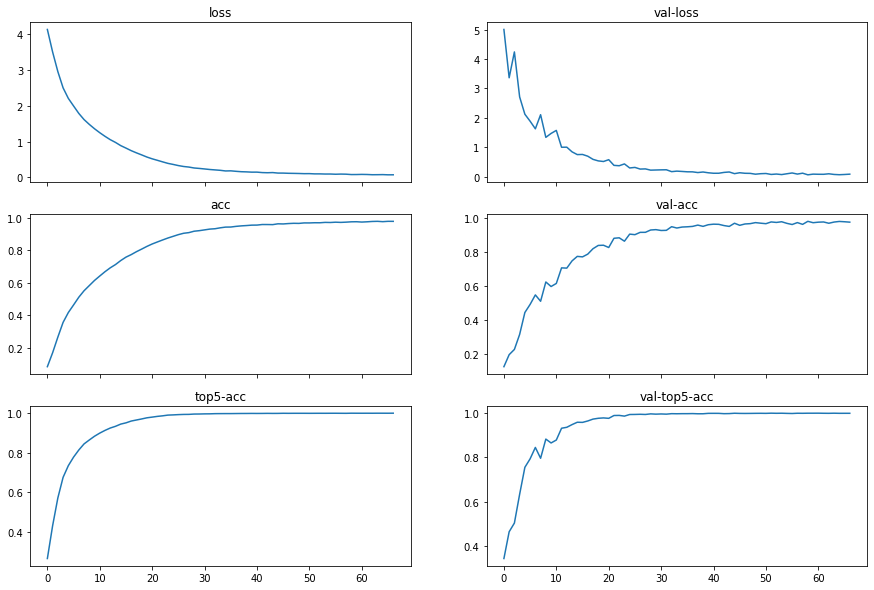

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history_resnet50.history['loss'])
ax[0, 1].plot(history_resnet50.history['val_loss'])
ax[1, 0].plot(history_resnet50.history['acc'])
ax[1, 1].plot(history_resnet50.history['val_acc'])
ax[2, 0].plot(history_resnet50.history['top5_acc'])
ax[2, 1].plot(history_resnet50.history['val_top5_acc'])


In [22]:
# Get the best performing scores:
best_val_accuracy = max(history_resnet50.history['val_acc']) * 100
best_val_top5accuracy = max(history_resnet50.history['val_top5_acc']) * 100

# Print out the results:
print("Best Validation Accuracy: {:2.2f}%".format(best_val_accuracy))
print("Best Validation Top 5 Accuracy: {:2.2f}%".format(best_val_top5accuracy))

Best Validation Accuracy: 97.97%
Best Validation Top 5 Accuracy: 99.97%


### Observation:

Comparing this to the self-implement ResNet (Validation Accuracy = 66%), the validation results can be seen to be much better with ~30% increase in its accuracy. This should mean that the model is better at recognising the test images.

## 6 - Plot the Predictions:

These images are taken from the web randomly.

In [23]:
# Import the required libraries:
import glob
import numpy as np
from predictions_utility import *

### 6.1 - Load the images in:

In [24]:
# Locate the folder of images:
testing_filenames = glob.glob(os.path.join('Testing Images from Web', '*'))

# testing_filenames = glob.glob(os.path.join('res', '*'))

# Load in the images:
testing_imgs = np.asarray( [load_image(file, size = input_shape[:2]) for file in testing_filenames] )

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (15, 224, 224, 3)


## 6.2 - Plot:

Use the model to predict on the "image per image" or "batch per batch",  and display the results of its predictions.

NOTE: The model was trainied on CIFAR image data where these images are originally 32x32 pixels, then these were scaled up to 224x224 pixels as suggest by ResNet creators for training. This means that the resulting imaages had important artifacts or low quality features.

To test the model on images of the same quality, the testing images will be resized to 32x32 pixel and then followed by another resizing to an expected input size of 224x224 pixels.

predicted class probabilities: (15, 100)


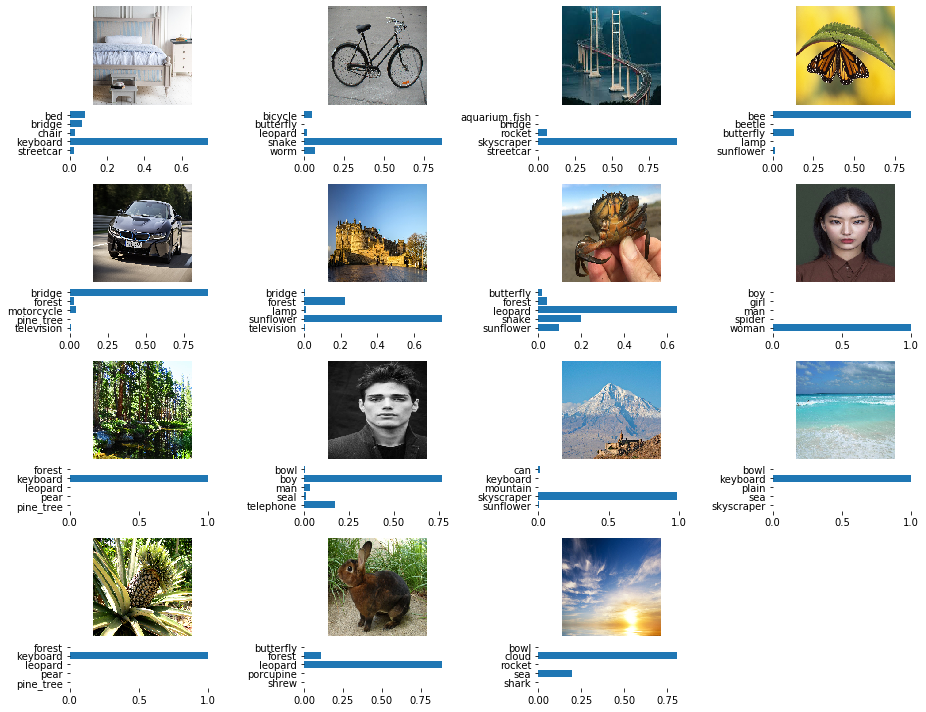

In [25]:
# Define the batch of images:
img_batch = testing_imgs[:16]

# Perform the testing image resize:
cifar_original_imgSize = cifarData_info.features['image'].shape[:2]

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = cifar_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = input_shape[:2])

# Predictions:
predictions = resnet50.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))

# Plot: using the utility funcs.
class_readable_labels = cifarData_info.features['label'].names
top5_labels, top5_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images = img_batch,
                    topk_labels = top5_labels,
                    topk_probabilities = top5_probs)


### Conclusion:

Looking at the results, the model did not perform well in terms to predictions with a great amount of certainty because it only managed to guess 1/15 images correctly. If the Top 5 were considered, the model performed much better with 10/15 images where the correct labels are in the top 5 guesses.

## 6.3 - Load the images in: from 2nd test folder

In [26]:
# Locate the folder of images:
testing_filenames = glob.glob(os.path.join('Testing Images from Web 2', '*'))

# testing_filenames = glob.glob(os.path.join('res', '*'))

# Load in the images:
testing_imgs = np.asarray( [load_image(file, size = input_shape[:2]) for file in testing_filenames] )

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (16, 224, 224, 3)


## 6.4 - Plot:

predicted class probabilities: (16, 100)


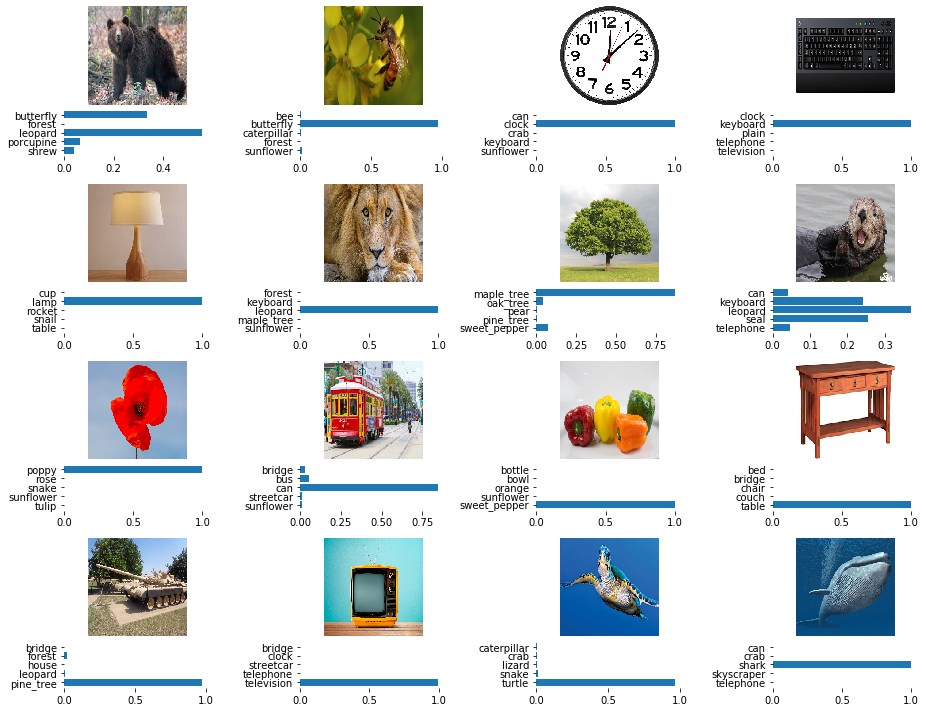

In [27]:
# Define the batch of images:
img_batch = testing_imgs[:16]

# Perform the testing image resize:
cifar_original_imgSize = cifarData_info.features['image'].shape[:2]

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = cifar_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = input_shape[:2])

# Predictions:
predictions = resnet50.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))

# Plot: using the utility funcs.
class_readable_labels = cifarData_info.features['label'].names
top5_labels, top5_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images = img_batch,
                    topk_labels = top5_labels,
                    topk_probabilities = top5_probs)


# Conclusions:

Interestingly, even with a better trained model, it was only able to get 8/16 images correctly with a great amount of certainty. If the Top-5 results for each of the images were considered, the resulting correct guesses would be 11/16 images. Overall, this means that the model has done quite well considering that the image dataset for 100 classes is quite small for the model to be trained succesfully to perform with greater prediction outcomes.

## Summary:

Although this is not the end of this project, it does conclude the 1st notebook relevant to the theory of these advanced deep learning models. Please go to check out __Notebook 5__ for the __Getting Models from TensorFlow Hub__.